In [1]:
import numpy as np 
import pandas as pd
import re
import sqlite3
import pickle # save model
from sklearn.model_selection import train_test_split # used to split the data into training and testing sets
from sklearn.neural_network import MLPClassifier # used as the machine learning algorithm
from sklearn.model_selection import GridSearchCV # used to tune hyperparameters
from sklearn.pipeline import Pipeline # used to build the machine learning pipeline
from sklearn.compose import ColumnTransformer # part of pipeline used to handle columns
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report # used to evaluate the performance of the model.
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer #convert input_text data into numerical data.
from sklearn.feature_extraction.text import TfidfVectorizer

The sqlite3.connect function is used to connect to the database. The pd.read_sql_query function is used to execute a SQL query and read the results into a pandas DataFrame. The query variable contains the SQL query to be executed, and the conn variable is the connection object returned by sqlite3.connect. The data.head() function is used to display the first few rows of the DataFrame.

In [2]:
conn = sqlite3.connect(r'..\database.db', check_same_thread=False)
query = 'SELECT * FROM new_data'
data = pd.read_sql_query (query, conn)
data.head()

,Tweet,Label
0,warung dimiliki pengusaha pabrik tahu sudah pu...,positive
1,mohon ulama lurus mmbri hujjah partai harus di...,neutral
2,lokasi strategis jalan sumatra bandung tempat ...,positive
3,betapa bahagia saat unboxing paket barang bagu...,positive
4,aduh jadi mahasiswa jangan sombong kasih kartu...,negative


The data.Tweet.tolist() function is used to convert the Tweet column of the data DataFrame to a list. This will create a list of all the values in the Tweet column. 

In [3]:
data_vektor = data.Tweet.tolist()

EXTRACTION FEATURE
<p>The fit method is used to learn a vocabulary dictionary of all tokens in the raw documents. The transform method is used to transform the documents into a document-term matrix. The resulting matrix is a sparse matrix where each row represents a document and each column represents a token in the vocabulary. The value in each cell represents the frequency of the token in the corresponding document. The resulting matrix can be used as input to machine learning algorithms.

In [4]:
count_bow = CountVectorizer()
    
# melakukan fitting dan transformasi pada dokumen
count_bow.fit(data_vektor)

# melihat hasil representasi bag of words
BoW = count_bow.fit_transform(data_vektor)

In [5]:
count_tfidf = TfidfVectorizer()
    
# melakukan fitting dan transformasi pada dokumen
count_tfidf.fit(data_vektor)

# melihat hasil representasi bag of words
TFIDF = count_tfidf.fit_transform(data_vektor)

In [6]:
y = data.Label

Save a CountVectorizer object to a file using the pickle.dump function. The pickle.dump function is used to serialize the count_vect object and write it to a file named feature_New.pickle in binary mode. The open function is used to open the file in binary write mode (wb).

In [7]:
pickle.dump(count_bow, open(r"..\NN_Files\feature_BoW_stopword.pickle", "wb"))
pickle.dump(count_tfidf, open(r"..\NN_Files\feature_TFIDF_stopword.pickle", "wb"))

TRAIN - TEST SPLIT DATA
<p>Split data into training and testing sets using the train_test_split function from the sklearn.model_selection library. The train_test_split function is used to split the data into training and testing sets. The X and y variables contain the features and target variable, respectively. The test_size parameter is set to 0.20, which means that 20% of the data will be used for testing and 80% of the data will be used for training. The random_state parameter is set to 40, which means that the random number generator used by train_test_split will produce the same results every time the code is run. The resulting variables X_train, X_test, y_train, and y_test contain the training and testing sets of the features and target variable, respectively.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(BoW, y, test_size = 0.20, random_state = 40, shuffle=True)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(TFIDF, y, test_size = 0.20, random_state = 40, shuffle=True)

<8746x15528 sparse matrix of type '<class 'numpy.int64'>'
	with 157201 stored elements in Compressed Sparse Row format>

`MLPClassifier` is a neural network algorithm that can be used for classification tasks. It has several parameters that can be tuned to improve its performance. Here is an explanation of the parameters in your `parameter_grid`:

- `hidden_layer_sizes`: This parameter specifies the number of neurons in each hidden layer of the neural network. It is a list of integers, where each integer represents the number of neurons in a hidden layer. For example, `[1, 10]` means that there are two hidden layers, one with 1 neuron and one with 10 neurons.

- `activation`: This parameter specifies the activation function used in the neural network. The activation function is used to introduce non-linearity into the model. The possible values for this parameter are `'relu'`, `'tanh'`, and `'logistic'`.

- `learning_rate_init`: This parameter specifies the initial learning rate used by the neural network. The learning rate determines how quickly the model learns from the data.

- `alpha`: This parameter specifies the L2 penalty (regularization term) parameter. It is used to prevent overfitting of the model.

- `early_stopping`: This parameter specifies whether to use early stopping to terminate training when validation score is not improving. If set to `True`, training will stop when validation score is not improving by at least `tol` for `n_iter_no_change` consecutive iterations.


parameter_grid digunakan untuk mencari kombinasi hyperparameter terbaik untuk MLPClassifier. Jika kita tidak menggunakan parameter_grid, maka kita harus menentukan hyperparameter secara manual dan mencoba beberapa kombinasi hyperparameter untuk menemukan kombinasi terbaik yang dapat meningkatkan performa model. Dalam hal ini, GridSearchCV dapat mempercepat proses pencarian hyperparameter terbaik dan menghasilkan model yang lebih baik.

In [9]:
model = Pipeline([ ('algoritma', MLPClassifier()) ])
parameter_grid = {
    'algoritma__hidden_layer_sizes': [{i} for i in [1, 10]],
    'algoritma__activation': ['relu','tanh','logistic'],
    'algoritma__learning_rate_init' : [0.01],
    'algoritma__alpha': [0.1,0.01,1],
    'algoritma__early_stopping': [True]
} 
model_NN_BoW = GridSearchCV(model, parameter_grid)
model_NN_TFIDF = GridSearchCV(model, parameter_grid)

Trying to fit a machine learning model using the fit method of the GridSearchCV object. The X_train and y_train variables contain the features and target variable, respectively.

In [10]:
%%time
model_NN_BoW.fit(X_train,y_train)

CPU times: total: 22.2 s
Wall time: 3min 31s


GridSearchCV(estimator=Pipeline(steps=[('algoritma', MLPClassifier())]),
             param_grid={'algoritma__activation': ['relu', 'tanh', 'logistic'],
                         'algoritma__alpha': [0.1, 0.01, 1],
                         'algoritma__early_stopping': [True],
                         'algoritma__hidden_layer_sizes': [{1}, {10}],
                         'algoritma__learning_rate_init': [0.01]})

In [11]:
%%time
model_NN_TFIDF.fit(X_train_2,y_train_2)

CPU times: total: 37.4 s
Wall time: 6min 22s


GridSearchCV(estimator=Pipeline(steps=[('algoritma', MLPClassifier())]),
             param_grid={'algoritma__activation': ['relu', 'tanh', 'logistic'],
                         'algoritma__alpha': [0.1, 0.01, 1],
                         'algoritma__early_stopping': [True],
                         'algoritma__hidden_layer_sizes': [{1}, {10}],
                         'algoritma__learning_rate_init': [0.01]})

 Trying to get the best hyperparameters for your machine learning model.

In [12]:
print("Best parameters of Model NN-BoW: ", model_NN_BoW.best_params_ )
print("Best parameters of Model NN-TFIDF: ", model_NN_TFIDF.best_params_ )

Best parameters of Model NN-BoW:  {'algoritma__activation': 'relu', 'algoritma__alpha': 0.1, 'algoritma__early_stopping': True, 'algoritma__hidden_layer_sizes': {10}, 'algoritma__learning_rate_init': 0.01}
Best parameters of Model NN-TFIDF:  {'algoritma__activation': 'relu', 'algoritma__alpha': 0.1, 'algoritma__early_stopping': True, 'algoritma__hidden_layer_sizes': {10}, 'algoritma__learning_rate_init': 0.01}


Save a machine learning model using the pickle.dump function. The pickle.dump function is used to serialize the model_NN object and write it to a file named model_NN.pickle in binary mode. The open function is used to open the file in binary write mode (wb).

In [13]:
pickle.dump(model_NN_BoW, open(r"..\NN_Files\model_NN_BoW_stopword.pickle", 'wb'))
pickle.dump(model_NN_TFIDF, open(r"..\NN_Files\model_NN_TFIDF_stopword.pickle", 'wb'))

## EVALUATION
<p>Pada dasarnya, tujuan dari machine learning adalah untuk membuat model yang dapat memprediksi data baru dengan akurasi yang tinggi. Untuk mencapai tujuan tersebut, model harus dilatih menggunakan data yang cukup dan representatif. Oleh karena itu, data yang digunakan untuk melatih model biasanya dibagi menjadi dua bagian, yaitu data training dan data testing. Data training digunakan untuk melatih model, sedangkan data testing digunakan untuk menguji performa model yang sudah dilatih sebelumnya ketika menemukan data baru yang belum pernah dilihat sebelumnya. Dalam hal ini, pengujian dengan seluruh dataset dapat memberikan gambaran tentang performa model secara keseluruhan, sedangkan pengujian dengan data training dan data testing dapat memberikan gambaran tentang performa model pada data yang belum pernah dilihat sebelumnya. Dengan demikian, pengujian dengan seluruh dataset, data training, dan data testing sangat penting untuk mengevaluasi performa model dan memastikan bahwa model dapat memprediksi data baru dengan akurasi yang tinggi.

EVALUASI MODEL NN-BoW

In [14]:
y_pred_NN_BoW_Dataset = model_NN_BoW.predict(BoW)

In [15]:
print(classification_report(y,y_pred_NN_BoW_Dataset))

conf_mat_NN_BoW_Dataset = confusion_matrix(y,y_pred_NN_BoW_Dataset)
print("Confusion matrix:\n", conf_mat_NN_BoW_Dataset)

              precision    recall  f1-score   support

    negative       0.92      0.93      0.93      3412
     neutral       0.95      0.89      0.92      1138
    positive       0.96      0.97      0.96      6383

    accuracy                           0.95     10933
   macro avg       0.94      0.93      0.94     10933
weighted avg       0.95      0.95      0.95     10933

Confusion matrix:
 [[3181   34  197]
 [  75 1010   53]
 [ 199   21 6163]]


In [16]:
y_pred_NN_BoW_Train = model_NN_BoW.predict(X_train)

In [17]:
print(classification_report(y_train,y_pred_NN_BoW_Train))

conf_mat_NN_BoW_Train = confusion_matrix(y_train,y_pred_NN_BoW_Train)
print("Confusion matrix:\n", conf_mat_NN_BoW_Train)

              precision    recall  f1-score   support

    negative       0.95      0.96      0.96      2725
     neutral       0.97      0.94      0.96       907
    positive       0.98      0.98      0.98      5114

    accuracy                           0.97      8746
   macro avg       0.97      0.96      0.96      8746
weighted avg       0.97      0.97      0.97      8746

Confusion matrix:
 [[2624   13   88]
 [  30  850   27]
 [ 112    9 4993]]


In [18]:
y_pred_NN_BoW_Test = model_NN_BoW.predict(X_test)

In [19]:
print(classification_report(y_test,y_pred_NN_BoW_Test))

conf_mat_NN_BoW_Test = confusion_matrix(y_test,y_pred_NN_BoW_Test)
print("Confusion matrix:\n", conf_mat_NN_BoW_Test)

              precision    recall  f1-score   support

    negative       0.81      0.81      0.81       687
     neutral       0.83      0.69      0.75       231
    positive       0.90      0.92      0.91      1269

    accuracy                           0.86      2187
   macro avg       0.84      0.81      0.82      2187
weighted avg       0.86      0.86      0.86      2187

Confusion matrix:
 [[ 557   21  109]
 [  45  160   26]
 [  87   12 1170]]


EVALUASI MODEL NN-TFIDF

In [20]:
y_pred_NN_TFIDF_Dataset = model_NN_TFIDF.predict(TFIDF)

In [21]:
print(classification_report(y,y_pred_NN_TFIDF_Dataset))

conf_mat_NN_TFIDF_Dataset = confusion_matrix(y,y_pred_NN_TFIDF_Dataset)
print("Confusion matrix:\n", conf_mat_NN_TFIDF_Dataset)

              precision    recall  f1-score   support

    negative       0.91      0.92      0.91      3412
     neutral       0.94      0.88      0.91      1138
    positive       0.95      0.96      0.96      6383

    accuracy                           0.94     10933
   macro avg       0.94      0.92      0.93     10933
weighted avg       0.94      0.94      0.94     10933

Confusion matrix:
 [[3127   26  259]
 [  89 1003   46]
 [ 209   35 6139]]


In [22]:
y_pred_NN_TFIDF_Train = model_NN_TFIDF.predict(X_train_2)

In [23]:
print(classification_report(y_train, y_pred_NN_TFIDF_Train))

conf_mat_NN_TFIDF_Train = confusion_matrix(y_train, y_pred_NN_TFIDF_Train)
print("Confusion matrix:\n", conf_mat_NN_TFIDF_Train)

              precision    recall  f1-score   support

    negative       0.94      0.94      0.94      2725
     neutral       0.97      0.93      0.95       907
    positive       0.96      0.97      0.97      5114

    accuracy                           0.96      8746
   macro avg       0.96      0.95      0.95      8746
weighted avg       0.96      0.96      0.96      8746

Confusion matrix:
 [[2563    9  153]
 [  36  842   29]
 [ 122   17 4975]]


In [24]:
y_pred_NN_TFIDF_Test = model_NN_TFIDF.predict(X_test_2)

In [25]:
print(classification_report(y_test, y_pred_NN_TFIDF_Test))

conf_mat_NN_TFIDF_Test = confusion_matrix(y_test, y_pred_NN_TFIDF_Test)
print("Confusion matrix:\n", conf_mat_NN_TFIDF_Test)
conf_mat_NN_TFIDF_Test

              precision    recall  f1-score   support

    negative       0.80      0.82      0.81       687
     neutral       0.82      0.70      0.75       231
    positive       0.90      0.92      0.91      1269

    accuracy                           0.86      2187
   macro avg       0.84      0.81      0.83      2187
weighted avg       0.86      0.86      0.86      2187

Confusion matrix:
 [[ 564   17  106]
 [  53  161   17]
 [  87   18 1164]]


array([[ 564,   17,  106],
       [  53,  161,   17],
       [  87,   18, 1164]], dtype=int64)

## CROSS VALIDATION
<p>Cross-validation dapat membantu mengidentifikasi apakah model mengalami overfitting atau underfitting dengan membagi data menjadi subset untuk training dan testing. Jika model memiliki performa yang baik pada data training tetapi performa yang buruk pada data testing, maka model mungkin mengalami overfitting. Sebaliknya, jika model memiliki performa yang buruk pada data training dan data testing, maka model mungkin mengalami underfitting.

CROSS VALIDATION - WITH PIPELINE PARAMETER

This code will split your dataset into n_splits folds, train an MLPClassifier model on each fold, and test the model on the remaining folds. The GridSearchCV object will perform a search over the parameter grid to find the best hyperparameters for the model. The best hyperparameters will be used to create a new MLPClassifier object, which will be used to obtain the predictions using cross_val_predict. Finally, the confusion matrix, f1 score, precision score, recall score, and accuracy score will be computed and printed.

In [26]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict

kf = KFold(n_splits=5, shuffle=False)
accuracies = []

for iteration, data in enumerate(kf.split(BoW), start=1):

  data_train = BoW[data[0]]
  target_train = y[data[0]]

  data_test = BoW[data[1]]
  target_test = y[data[1]]

  # Create an MLPClassifier object
  clf = MLPClassifier()

  # Create a pipeline object
  pipeline = Pipeline(steps=[('algoritma', clf)])

  # Define the parameter grid
  parameter_grid = {
      'algoritma__hidden_layer_sizes': [{i} for i in [1, 10]],
      'algoritma__activation': ['relu','tanh','logistic'],
      'algoritma__learning_rate_init' : [0.01],
      'algoritma__alpha': [0.1,0.01,1],
      'algoritma__early_stopping': [True]
  }

  # Create a GridSearchCV object
  grid_search = GridSearchCV(pipeline, parameter_grid, cv=kf)

  # Fit the GridSearchCV object to the data
  grid_search.fit(data_train, target_train)

  predictions = grid_search.predict(data_test)

  # Use cross_val_predict to obtain the predictions
  y_prediction = cross_val_predict(grid_search.best_estimator_, data_train, target_train, cv=kf)

  # for the current fold only

  accuracy = accuracy_score(target_test,predictions)

  print("Training ke-", iteration)
  print()
  print(classification_report(target_test,predictions))
  accuracies.append(accuracy)
  # Compute the confusion matrix
  conf_mat = confusion_matrix(target_train, y_prediction)
  # Print the confusion matrix
  print("Confusion matrix:\n", conf_mat)
  print()
  print("Best parameters: ", grid_search.best_params_)
  print()
  print("======================================================================")
  print()

# this is the average accuracy over all folds

average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)



Training ke- 1

              precision    recall  f1-score   support

    negative       0.79      0.81      0.80       650
     neutral       0.81      0.70      0.75       235
    positive       0.91      0.92      0.91      1302

    accuracy                           0.86      2187
   macro avg       0.83      0.81      0.82      2187
weighted avg       0.86      0.86      0.86      2187

Confusion matrix:
 [[2302   83  377]
 [ 200  607   96]
 [ 381   47 4653]]

Best parameters:  {'algoritma__activation': 'relu', 'algoritma__alpha': 0.01, 'algoritma__early_stopping': True, 'algoritma__hidden_layer_sizes': {10}, 'algoritma__learning_rate_init': 0.01}


Training ke- 2

              precision    recall  f1-score   support

    negative       0.83      0.80      0.81       683
     neutral       0.79      0.79      0.79       206
    positive       0.91      0.92      0.91      1298

    accuracy                           0.87      2187
   macro avg       0.84      0.84      0.84    

CROSS VALIDATION NN-TFIDF

In [27]:
accuracies = []

for iteration, data in enumerate(kf.split(TFIDF), start=1):

  data_train = TFIDF[data[0]]
  target_train = y[data[0]]

  data_test = TFIDF[data[1]]
  target_test = y[data[1]]

  # Create an MLPClassifier object
  clf = MLPClassifier()

  # Create a pipeline object
  pipeline = Pipeline(steps=[('algoritma', clf)])

  # Define the parameter grid
  parameter_grid = {
      'algoritma__hidden_layer_sizes': [{i} for i in [1, 10]],
      'algoritma__activation': ['relu','tanh','logistic'],
      'algoritma__learning_rate_init' : [0.01],
      'algoritma__alpha': [0.1,0.01,1],
      'algoritma__early_stopping': [True]
  }

  # Create a GridSearchCV object
  grid_search = GridSearchCV(pipeline, parameter_grid, cv=kf)

  # Fit the GridSearchCV object to the data
  grid_search.fit(data_train, target_train)

  predictions = grid_search.predict(data_test)

  # Use cross_val_predict to obtain the predictions
  y_prediction = cross_val_predict(grid_search.best_estimator_, data_train, target_train, cv=kf)

  # for the current fold only

  accuracy = accuracy_score(target_test,predictions)

  print("Training ke-", iteration)
  print()
  print(classification_report(target_test,predictions))
  accuracies.append(accuracy)
  # Compute the confusion matrix
  conf_mat = confusion_matrix(target_train, y_prediction)
  # Print the confusion matrix
  print("Confusion matrix:\n", conf_mat)
  print()
  print("Best parameters: ", grid_search.best_params_)
  print()
  print("======================================================================")
  print()

# this is the average accuracy over all folds

average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

Training ke- 1

              precision    recall  f1-score   support

    negative       0.79      0.84      0.81       650
     neutral       0.80      0.74      0.77       235
    positive       0.93      0.91      0.92      1302

    accuracy                           0.87      2187
   macro avg       0.84      0.83      0.83      2187
weighted avg       0.87      0.87      0.87      2187

Confusion matrix:
 [[2272   81  409]
 [ 201  608   94]
 [ 378   59 4644]]

Best parameters:  {'algoritma__activation': 'relu', 'algoritma__alpha': 0.1, 'algoritma__early_stopping': True, 'algoritma__hidden_layer_sizes': {10}, 'algoritma__learning_rate_init': 0.01}


Training ke- 2

              precision    recall  f1-score   support

    negative       0.80      0.81      0.81       683
     neutral       0.83      0.63      0.72       206
    positive       0.90      0.93      0.92      1298

    accuracy                           0.87      2187
   macro avg       0.85      0.79      0.81     

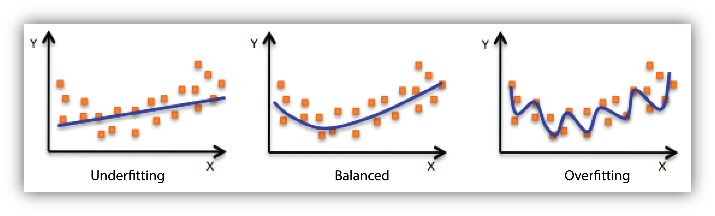
<p> Model yang overfitting dapat menghasilkan akurasi yang sangat tinggi pada data pelatihan, tetapi akurasi yang lebih rendah pada data pengujian 1. Berikut adalah contoh akurasi model machine learning yang mengalami overfitting:

Model yang dibuat untuk memprediksi harga rumah di suatu daerah memiliki akurasi 99% pada data pelatihan, tetapi hanya 50% pada data pengujian 2.
Model yang dibuat untuk mengklasifikasikan gambar memiliki akurasi 95% pada data pelatihan, tetapi hanya 60% pada data pengujian 
<p>Nilai delta rendah : Nilai delta adalah selisih antara akurasi model saat diterapkan pada dataset train dan test.

In [28]:
input_text = """Dia memakan kue dengan lahap dan beringas jelek"""
def cleansing(text):
    text = text.lower() # Mengubah teks menjadi huruf kecil
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', ' ', text)# Menghapus URL dan tautan
    text = re.sub('url',' ', text)
    text = re.sub(r'pic.twitter.com.[\w]+', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text) # Menghapus karakter yang tidak diinginkan, termasuk angka
    text = text.replace('user', '')# Menghapus kata 'user'
    text = re.sub(' +', ' ', text)# Menghapus spasi berlebih
    text = text.replace('\n', ' ')# Menghapus karakter \n (newline)
    return text
    
def normalize_text(text):
    data_alay = pd.read_sql_query('select * from kamusalay', conn)
    dict_alay = dict(zip(data_alay['alay'], data_alay['normal'])) #Membungkus data teks_alay dan teks baku menjadi dictionary
    text_list = text.split()
    
    text_normal_list = [dict_alay.get(word, word) for word in text_list] #Mengambil nilai baku pada data teks_baku
    
    text_normal = ' '.join(text_normal_list) #mengganti teks yang tidak baku menjadi baku
    return text_normal.strip()

def stopword_removal(text):
    q_stopword = 'SELECT * FROM stopword'
    t_stopword = pd.read_sql_query(q_stopword, conn)
    stopword_words = set(t_stopword['STOPWORD'])
    words = text.split()
    filtered_words = [word for word in words if word not in stopword_words]
    return ' '.join(filtered_words)

def preprocess_text(text):
    text = cleansing(text)
    text = normalize_text(text)
    # text = stopword_removal(text)
    return text

count_vect = pickle.load(open(r"..\NN_Files\feature_BoW_stopword.pickle", "rb"))
model_NN = pickle.load(open(r"..\NN_Files\model_NN_BoW_stopword.pickle", "rb"))

sentiment = ['negative', 'neutral', 'positive']

text_clean = [preprocess_text(input_text)]
text_feture_extration = count_vect.transform(text_clean)

prediction = model_NN.predict(text_feture_extration)
polarity = np.argmax(prediction[0])
hasil = sentiment[polarity]

print("Input Text: %s" % input_text)
print("Text Preprocessing: %s" % text_clean[0])
print("Extraction Feature:\n%s" % text_feture_extration)
print("Sentiment: %s" % hasil)

Input Text: Dia memakan kue dengan lahap dan beringas jelek
Text Preprocessing: dia memakan kue dengan lahap dan beringas jelek
Extraction Feature:
  (0, 5834)	1
  (0, 7154)	1
  (0, 7229)	1
  (0, 8223)	1
Sentiment: negative


In [29]:
%%time
model_NN_TFIDF.fit(TFIDF,y)
pickle.dump(model_NN_TFIDF, open(r"..\NN_Files\model_NN_TFIDF_Dataset_stopword.pickle", 'wb'))

CPU times: total: 20.3 s
Wall time: 5min 30s
